In [2]:
import pandas as pd
import numpy as np
import json
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import shap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.cluster import HDBSCAN


## 1. Create different datasets based on the store. (Different in sizes and distributions)

In [3]:
main_train_df = pd.read_csv("main_train_df.csv")

In [4]:
# A dict of all the store branches
stores = {}
for store_id in main_train_df["Store"].unique():
    df_store = main_train_df[main_train_df["Store"] == store_id]
    stores[f"store_{store_id}"] = df_store

In [5]:
stores["store_2"].columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'Sales'],
      dtype='object')

In [6]:
len(stores)

1115

## 2. Compute metadata info

In [7]:
# The system learns to choose the best model based on dataset characteristics.

In [8]:
'''
# Prevoius simple meta data calculation which did not capture everything fully 
def compute_metadata(df):
    return {
        "num_rows": len(df),
        "promo_fraction": df["Promo"].mean(),
        "promo2_fraction": df["Promo2"].mean(),
        "schoolholiday_fraction": df["SchoolHoliday"].mean(),
        "mean_sales": df["Sales"].mean(),
        "std_sales": df["Sales"].std()
    }
'''

'\n# Prevoius simple meta data calculation which did not capture everything fully \ndef compute_metadata(df):\n    return {\n        "num_rows": len(df),\n        "promo_fraction": df["Promo"].mean(),\n        "promo2_fraction": df["Promo2"].mean(),\n        "schoolholiday_fraction": df["SchoolHoliday"].mean(),\n        "mean_sales": df["Sales"].mean(),\n        "std_sales": df["Sales"].std()\n    }\n'

In [15]:
'''
def compute_metadata(df):
    meta = {}

    # Size
    meta["num_rows"] = len(df)

    # Temporal / categorical distribution
    for col in ["DayOfWeek", "Month", "WeekOfYear"]:
        if col in df:
            counts = df[col].value_counts(normalize=True)
            meta[f"{col.lower()}_entropy"] = -(counts * np.log2(counts + 1e-12)).sum()
        else:
            meta[f"{col.lower()}_entropy"] = 0

    # Promo / SchoolHoliday
    meta["promo_fraction"] = df["Promo"].mean() if "Promo" in df else 0
    meta["promo2_fraction"] = df["Promo2"].mean() if "Promo2" in df else 0
    meta["schoolholiday_fraction"] = df["SchoolHoliday"].mean() if "SchoolHoliday" in df else 0

    # Competition
    if "CompetitionDistance" in df:
        meta["competition_distance_mean"] = df["CompetitionDistance"].fillna(0).mean()
    

    # Open fraction
    if "Open" in df:
        meta["open_fraction"] = df["Open"].mean()

    return meta
'''

'\ndef compute_metadata(df):\n    meta = {}\n\n    # Size\n    meta["num_rows"] = len(df)\n\n    # Temporal / categorical distribution\n    for col in ["DayOfWeek", "Month", "WeekOfYear"]:\n        if col in df:\n            counts = df[col].value_counts(normalize=True)\n            meta[f"{col.lower()}_entropy"] = -(counts * np.log2(counts + 1e-12)).sum()\n        else:\n            meta[f"{col.lower()}_entropy"] = 0\n\n    # Promo / SchoolHoliday\n    meta["promo_fraction"] = df["Promo"].mean() if "Promo" in df else 0\n    meta["promo2_fraction"] = df["Promo2"].mean() if "Promo2" in df else 0\n    meta["schoolholiday_fraction"] = df["SchoolHoliday"].mean() if "SchoolHoliday" in df else 0\n\n    # Competition\n    if "CompetitionDistance" in df:\n        meta["competition_distance_mean"] = df["CompetitionDistance"].fillna(0).mean()\n\n\n    # Open fraction\n    if "Open" in df:\n        meta["open_fraction"] = df["Open"].mean()\n\n    return meta\n'

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def compute_metadata(df):
    meta = {}

    # ---------------------------------------------------
    # 1. Dataset size
    # ---------------------------------------------------
    meta["num_rows"] = len(df)

    # ---------------------------------------------------
    # 2. Temporal distribution entropy
    # ---------------------------------------------------
    for col in ["DayOfWeek", "Month", "WeekOfYear"]:
        if col in df:
            p = df[col].value_counts(normalize=True)
            meta[f"{col.lower()}_entropy"] = -(p * np.log2(p + 1e-12)).sum()
        else:
            meta[f"{col.lower()}_entropy"] = 0.0

    # ---------------------------------------------------
    # 3. Binary feature fractions
    # ---------------------------------------------------
    for col in ["Promo", "Promo2", "SchoolHoliday", "Open"]:
        if col in df:
            meta[f"{col.lower()}_fraction"] = df[col].mean()
        else:
            meta[f"{col.lower()}_fraction"] = 0.0

    # ---------------------------------------------------
    # 4. Competition distance statistics
    # ---------------------------------------------------
    if "CompetitionDistance" in df:
        values = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
        meta["competition_distance_mean"] = values.mean()
        meta["competition_distance_std"] = values.std()
    else:
        meta["competition_distance_mean"] = 0.0
        meta["competition_distance_std"] = 0.0

    # ---------------------------------------------------
    # 5. Feature distribution shape: skew, kurtosis, CV
    # ---------------------------------------------------
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    per_feature_skew = []
    per_feature_kurt = []
    per_feature_cv   = []

    for col in numeric_cols:
        col_values = df[col].dropna().values

        if len(col_values) > 1:
            per_feature_skew.append(pd.Series(col_values).skew())
            per_feature_kurt.append(pd.Series(col_values).kurtosis())
            per_feature_cv.append(np.std(col_values) / (np.mean(col_values) + 1e-9))
        else:
            per_feature_skew.append(0)
            per_feature_kurt.append(0)
            per_feature_cv.append(0)

    meta["avg_skewness"] = np.mean(per_feature_skew)
    meta["avg_kurtosis"] = np.mean(per_feature_kurt)
    meta["avg_coef_variation"] = np.mean(per_feature_cv)
    meta["std_coef_variation"] = np.std(per_feature_cv)

    # ---------------------------------------------------
    # 6. PCA: intrinsic dimensionality of features
    # ---------------------------------------------------
    try:
        scaled = df[numeric_cols].fillna(df[numeric_cols].median())
        pca = PCA()
        pca.fit(scaled)

        # How much variance the 1st component explains
        meta["pca_var_first"] = pca.explained_variance_ratio_[0]

        # How many components needed for 90% variance
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        meta["pca_components_90"] = int(np.searchsorted(cumvar, 0.90) + 1)

    except Exception:
        meta["pca_var_first"] = 0.0
        meta["pca_components_90"] = len(numeric_cols)

    return meta


## 3. Build a dataset of datasets

In [23]:
meta_rows = []
for name, df in stores.items():
    m = compute_metadata(df)
    m["label"] = name      # group name
    meta_rows.append(m)

meta_df = pd.DataFrame(meta_rows)

/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [24]:
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,open_fraction,competition_distance_mean,competition_distance_std,avg_skewness,avg_kurtosis,avg_coef_variation,std_coef_variation,pca_var_first,pca_components_90,label
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,0.839838,540.0,0.0,0.040635,-0.328238,0.413694,0.571524,0.000000,16,store_44
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,0.827260,8090.0,0.0,0.032733,-0.348204,0.415226,0.575254,0.000000,16,store_346
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,0.842175,670.0,0.0,0.040265,-0.279463,0.419648,0.601131,0.000000,16,store_331
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,0.831800,9230.0,0.0,0.036103,-0.331344,0.414755,0.576864,0.999966,1,store_572
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,0.828722,210.0,0.0,0.059790,-0.397473,0.414185,0.561782,0.000000,16,store_1014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,0.829071,15720.0,0.0,0.028874,-0.325971,0.419345,0.589805,0.000000,16,store_588
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,0.837618,2320.0,0.0,0.041210,-0.347262,0.411012,0.562498,0.000000,16,store_486
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,0.818182,7240.0,0.0,0.048305,-0.423988,0.414104,0.555958,0.000000,16,store_917
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,0.837550,2850.0,0.0,0.032376,-0.349788,0.415781,0.573288,0.000000,16,store_683


In [18]:
#meta_df.to_csv("meta_df.csv", index = False)

In [10]:
meta_df = pd.read_csv("meta_df.csv")
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,competition_distance_mean,open_fraction,label
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,540.0,0.839838,store_44
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,8090.0,0.827260,store_346
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,670.0,0.842175,store_331
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,9230.0,0.831800,store_572
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,210.0,0.828722,store_1014
...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,15720.0,0.829071,store_588
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,2320.0,0.837618,store_486
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,7240.0,0.818182,store_917
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,2850.0,0.837550,store_683


### cluster based on the meta data and use it as a meta feature
1. HDBSCAN
2. KMeans


### HBDSCAN

In [ ]:
X = meta_df.drop(columns=[ "label"   ])
hdb = HDBSCAN(min_cluster_size=10)
hdb_labels = hdb.fit_predict(X)

# assign cluster label to meta_df
meta_df["cluster"] = hdb_labels
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,open_fraction,competition_distance_mean,competition_distance_std,avg_skewness,avg_kurtosis,avg_coef_variation,std_coef_variation,pca_var_first,pca_components_90,label,cluster
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,0.839838,540.0,0.0,0.040635,-0.328238,0.413694,0.571524,0.000000,16,store_44,26
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,0.827260,8090.0,0.0,0.032733,-0.348204,0.415226,0.575254,0.000000,16,store_346,9
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,0.842175,670.0,0.0,0.040265,-0.279463,0.419648,0.601131,0.000000,16,store_331,26
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,0.831800,9230.0,0.0,0.036103,-0.331344,0.414755,0.576864,0.999966,1,store_572,-1
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,0.828722,210.0,0.0,0.059790,-0.397473,0.414185,0.561782,0.000000,16,store_1014,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,0.829071,15720.0,0.0,0.028874,-0.325971,0.419345,0.589805,0.000000,16,store_588,-1
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,0.837618,2320.0,0.0,0.041210,-0.347262,0.411012,0.562498,0.000000,16,store_486,24
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,0.818182,7240.0,0.0,0.048305,-0.423988,0.414104,0.555958,0.000000,16,store_917,-1
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,0.837550,2850.0,0.0,0.032376,-0.349788,0.415781,0.573288,0.000000,16,store_683,19


In [33]:
meta_df["competition_distance_mean"].fillna(meta_df["competition_distance_mean"].mean() , inplace=True)
meta_df["competition_distance_std"].fillna(meta_df["competition_distance_std"].mean() , inplace=True)

/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_2862/872570039.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_df["competition_distance_mean"].fillna(meta_df["competition_distance_mean"].mean() , inplace=True)
/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_2862/872570039.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

In [34]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_rows                   1115 non-null   int64  
 1   dayofweek_entropy          1115 non-null   float64
 2   month_entropy              1115 non-null   float64
 3   weekofyear_entropy         1115 non-null   float64
 4   promo_fraction             1115 non-null   float64
 5   promo2_fraction            1115 non-null   float64
 6   schoolholiday_fraction     1115 non-null   float64
 7   open_fraction              1115 non-null   float64
 8   competition_distance_mean  1115 non-null   float64
 9   competition_distance_std   1115 non-null   float64
 10  avg_skewness               1115 non-null   float64
 11  avg_kurtosis               1115 non-null   float64
 12  avg_coef_variation         1115 non-null   float64
 13  std_coef_variation         1115 non-null   float

In [22]:
meta_df["cluster"].value_counts()


cluster
-1     321
 26    249
 17     49
 25     40
 6      34
 22     34
 9      27
 1      24
 15     23
 27     22
 4      21
 11     20
 20     19
 23     18
 19     17
 13     17
 7      16
 18     16
 3      15
 24     15
 21     15
 5      14
 16     14
 8      14
 12     13
 10     12
 14     11
 2      11
 0      11
-3       3
Name: count, dtype: int64

In [557]:
# So many noise !!!

### KMeans

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(meta_df.drop(columns=["label"]))
kmeans = KMeans(n_clusters=3, random_state=42)
meta_df["cluster"] = kmeans.fit_predict(X_scaled)
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,open_fraction,competition_distance_mean,competition_distance_std,avg_skewness,avg_kurtosis,avg_coef_variation,std_coef_variation,pca_var_first,pca_components_90,label,cluster
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,0.839838,540.0,0.0,0.040635,-0.328238,0.413694,0.571524,0.000000,16,store_44,0
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,0.827260,8090.0,0.0,0.032733,-0.348204,0.415226,0.575254,0.000000,16,store_346,0
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,0.842175,670.0,0.0,0.040265,-0.279463,0.419648,0.601131,0.000000,16,store_331,0
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,0.831800,9230.0,0.0,0.036103,-0.331344,0.414755,0.576864,0.999966,1,store_572,2
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,0.828722,210.0,0.0,0.059790,-0.397473,0.414185,0.561782,0.000000,16,store_1014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,0.829071,15720.0,0.0,0.028874,-0.325971,0.419345,0.589805,0.000000,16,store_588,0
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,0.837618,2320.0,0.0,0.041210,-0.347262,0.411012,0.562498,0.000000,16,store_486,0
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,0.818182,7240.0,0.0,0.048305,-0.423988,0.414104,0.555958,0.000000,16,store_917,0
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,0.837550,2850.0,0.0,0.032376,-0.349788,0.415781,0.573288,0.000000,16,store_683,0


In [36]:
meta_df["cluster"].value_counts()

cluster
0    677
2    259
1    179
Name: count, dtype: int64

In [621]:
meta_df[meta_df["cluster"] == 2]["group"].value_counts()

group
easy      142
medium     27
hard       11
Name: count, dtype: int64

In [622]:
meta_df[meta_df["cluster"] == 1]["group"].value_counts()

group
easy      319
medium     55
hard       41
Name: count, dtype: int64

In [623]:
meta_df[meta_df["cluster"] == 0]["group"].value_counts()

group
easy      399
medium     69
hard       52
Name: count, dtype: int64

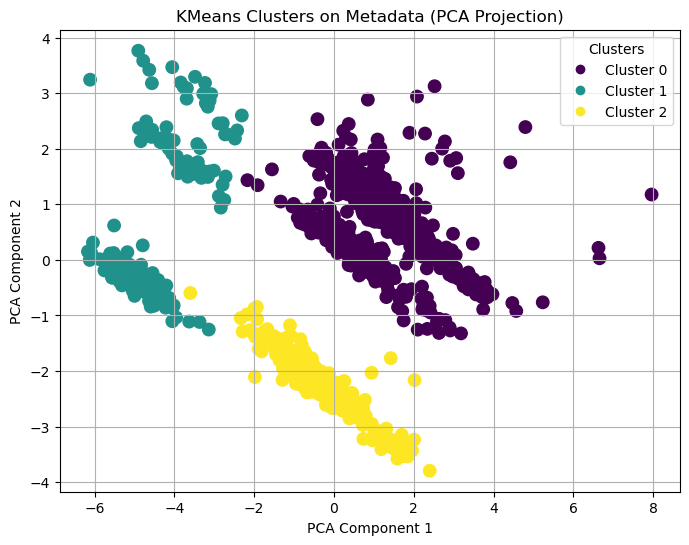

In [49]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    c=meta_df["cluster"],
    s=80
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters on Metadata (PCA Projection)")
plt.grid(True)

handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(len(set(meta_df['cluster'])))],
           title="Clusters")

plt.show()


In [625]:
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,competition_distance_mean,open_fraction,label,cluster,group
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,540.0,0.839838,store_44,0,easy
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,8090.0,0.827260,store_346,0,easy
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,670.0,0.842175,store_331,1,easy
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,9230.0,0.831800,store_572,1,easy
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,210.0,0.828722,store_1014,1,hard
...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,15720.0,0.829071,store_588,0,easy
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,2320.0,0.837618,store_486,1,easy
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,7240.0,0.818182,store_917,0,easy
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,2850.0,0.837550,store_683,0,medium


In [626]:
meta_df["cluster"].value_counts(())

cluster
0    520
1    415
2    180
Name: count, dtype: int64

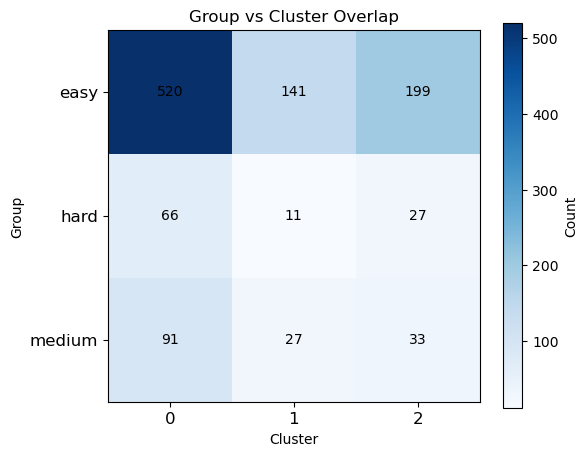

In [48]:
# compare cluster and group based on RMSE
ct = pd.crosstab(meta_df["group"], meta_df["cluster"])

plt.figure(figsize=(6,5))
plt.imshow(ct, cmap="Blues")

plt.colorbar(label="Count")

# Tick labels
plt.xticks(range(ct.shape[1]), ct.columns, fontsize=12)
plt.yticks(range(ct.shape[0]), ct.index, fontsize=12)

plt.xlabel("Cluster")
plt.ylabel("Group")
plt.title("Group vs Cluster Overlap")

# Annotate counts
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        plt.text(j, i, ct.iloc[i, j], ha="center", va="center", color="black")

plt.show()


## 4. Train a decision tree to group datasets 

3 approaches:
1. Train a decision tree on all the meta data. More interpretable than random forest in general but because there are many features in the meta data, it is not easy to underestand the logic perfectly. Also the percision is around 82%.
2. Train a random forest on all the meta data. The percision is around 81 percent. However, it is difficult to interpret the logic behind random forest because there are many trees in it. 
3. Train a random forest to detect the most important and influencial features, then train the decision tree on those features only. This had the better percision of 82%. Also it is more interpretabel and we can actually expand the tree and see the logic behind it. 

In [16]:
# For the purpose of grouping (training the decision tree),  use the one giant model for all the stores and Compute per-store RMSE and group them. 
# Stores with bad RMSE → “hard” group
# Stores with average RMSE → “medium”
# Stores with good RMSE → “easy”

In [56]:
global_predictor = TabularPredictor.load("AutogluonModels_5min/")

In [57]:

store_rmses = {}

for name, df in stores.items():
    perf = global_predictor.evaluate(df)
    store_rmses[name] = abs(perf["root_mean_squared_error"])
    store_mae[name] = abs(perf["mean_absolut_error"])

with open("store_rmses.json", "w") as f:
    json.dump(store_rmses, f, indent=4)


In [58]:
perf

{'root_mean_squared_error': np.float64(-411.9176833592794),
 'mean_squared_error': -169676.171875,
 'mean_absolute_error': -294.2866516113281,
 'r2': 0.9681721925735474,
 'pearsonr': 0.9840152935338294,
 'median_absolute_error': -210.7392578125}

In [37]:
with open("store_rmses.json", "r") as f:
    store_rmses = json.load(f)

store_rmses

{'store_44': 427.03360952640526,
 'store_346': 616.0141636042241,
 'store_331': 585.7557191763498,
 'store_572': 496.19500154528595,
 'store_1014': 1172.7844553164641,
 'store_630': 527.3283023811134,
 'store_545': 611.9078797703415,
 'store_201': 461.2834438514096,
 'store_1096': 435.2329064714001,
 'store_1111': 501.838246002304,
 'store_918': 421.03967884933223,
 'store_563': 491.76494007260885,
 'store_731': 584.2620050975702,
 'store_406': 479.52061758359474,
 'store_1040': 633.5579906504358,
 'store_232': 539.8962895168451,
 'store_134': 358.65287362622064,
 'store_155': 495.7663021096319,
 'store_221': 442.1392740704735,
 'store_250': 625.1845422574472,
 'store_94': 532.3873351593719,
 'store_653': 435.4116964003884,
 'store_578': 745.6263852670043,
 'store_65': 420.62767621076904,
 'store_872': 698.0791689271243,
 'store_1064': 584.5034327434446,
 'store_915': 520.6622854562602,
 'store_512': 549.3284800840382,
 'store_370': 530.0990407088868,
 'store_714': 430.48988606307967,


In [70]:
def assign_group_by_rmse(rmse):
    if rmse > 800:
        return "hard"
    elif rmse > 650:
        return "medium"
    else:
        return "easy"

meta_df["group"] = meta_df["label"].apply(lambda s: assign_group_by_rmse(store_rmses[s]))


In [71]:
meta_df["group"].value_counts()

group
easy      860
medium    151
hard      104
Name: count, dtype: int64

In [72]:
meta_df

,num_rows,dayofweek_entropy,month_entropy,weekofyear_entropy,promo_fraction,promo2_fraction,schoolholiday_fraction,open_fraction,competition_distance_mean,competition_distance_std,avg_skewness,avg_kurtosis,avg_coef_variation,std_coef_variation,pca_var_first,pca_components_90,label,cluster,group
0,743,2.805968,3.548680,5.653449,0.382234,0.0,0.177658,0.839838,540.0,0.0,0.040635,-0.328238,0.413694,0.571524,0.000000,16,store_44,0,easy
1,741,2.807163,3.557968,5.663192,0.387314,0.0,0.174089,0.827260,8090.0,0.0,0.032733,-0.348204,0.415226,0.575254,0.000000,16,store_346,0,easy
2,754,2.805550,3.559108,5.665416,0.393899,1.0,0.156499,0.842175,670.0,0.0,0.040265,-0.279463,0.419648,0.601131,0.000000,16,store_331,0,easy
3,761,2.806169,3.558102,5.665940,0.383706,1.0,0.173456,0.831800,9230.0,0.0,0.036103,-0.331344,0.414755,0.576864,0.999966,1,store_572,2,easy
4,759,2.805214,3.561942,5.670900,0.396574,1.0,0.183136,0.828722,210.0,0.0,0.059790,-0.397473,0.414185,0.561782,0.000000,16,store_1014,0,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,2.806443,3.563377,5.672781,0.379542,0.0,0.165545,0.829071,15720.0,0.0,0.028874,-0.325971,0.419345,0.589805,0.000000,16,store_588,0,easy
1111,739,2.806512,3.560380,5.671553,0.400541,1.0,0.181326,0.837618,2320.0,0.0,0.041210,-0.347262,0.411012,0.562498,0.000000,16,store_486,0,easy
1112,770,2.805744,3.560304,5.670247,0.385714,0.0,0.189610,0.818182,7240.0,0.0,0.048305,-0.423988,0.414104,0.555958,0.000000,16,store_917,0,easy
1113,751,2.805525,3.557460,5.664081,0.379494,0.0,0.177097,0.837550,2850.0,0.0,0.032376,-0.349788,0.415781,0.573288,0.000000,16,store_683,0,medium


### 1. Tree

In [73]:
# tree
X = meta_df.drop(columns=["group" , "label" ])
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [74]:
pred = tree_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.7849462365591398


In [66]:
'''
# expand tree model

plt.figure(figsize=(200,100))
tree.plot_tree(
    tree_model,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in tree_model.classes_]
)
plt.show()
'''

'\n# expand tree model\n\nplt.figure(figsize=(200,100))\ntree.plot_tree(\n    tree_model,\n    filled=True,\n    feature_names=X_train.columns,\n    class_names=[str(c) for c in tree_model.classes_]\n)\nplt.show()\n'

### 2. Random Forest

In [67]:
# random forest

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

X = meta_df.drop(columns=["group" , "label" ])
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.4982078853046595


### 3. Random Forest and then Decision Tree

In [69]:
# Random Forest

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

X = meta_df.drop(columns=["group" , "label" ])
y = meta_df["group"]

clf.fit(X, y)

importances =clf.feature_importances_
feature_names = X.columns

# Visualization
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df)

                      feature  importance
14              pca_var_first    0.115073
7               open_fraction    0.093679
8   competition_distance_mean    0.088836
11               avg_kurtosis    0.077985
10               avg_skewness    0.072587
12         avg_coef_variation    0.071312
1           dayofweek_entropy    0.069539
3          weekofyear_entropy    0.065426
2               month_entropy    0.064941
6      schoolholiday_fraction    0.064292
4              promo_fraction    0.063014
13         std_coef_variation    0.061417
0                    num_rows    0.060458
15          pca_components_90    0.013327
5             promo2_fraction    0.009138
16                    cluster    0.008977
9    competition_distance_std    0.000000


In [46]:
# Decision Tree
top_features = feat_imp_df["feature"].head(5).tolist()
X_top = meta_df[top_features]
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.25, random_state=42, stratify=y
)

top_features_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
top_features_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [47]:
X_test = X_test[top_features]
pred = top_features_tree.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.7849462365591398


In [364]:
'''
plt.figure(figsize=(200,100))
tree.plot_tree(
    top_features_tree,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in top_features_tree.classes_]
)
plt.show()
'''

'\nplt.figure(figsize=(200,100))\ntree.plot_tree(\n    top_features_tree,\n    filled=True,\n    feature_names=X_train.columns,\n    class_names=[str(c) for c in top_features_tree.classes_]\n)\nplt.show()\n'

## 5. Train an AutoGluon model for each group

In [113]:

# Train a model for each group
group_models = {}

for group in meta_df["group"].unique():
    print("Training model for group:", group)
    
    # get store names in this group
    store_names = meta_df[meta_df["group"] == group]["label"].tolist()
    
    # merge datasets from all stores in this group
    group_df = pd.concat([stores[name] for name in store_names], ignore_index=True)
    
    # train model for this group
    predictor = TabularPredictor(
        label="Sales",
        path=f"Models_group/{group}/"
    ).fit(
        group_df,
        presets="best",
        time_limit=600,
        dynamic_stacking=False
    )

    group_models[group] = predictor
    

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.77 GB / 8.00 GB (22.1%)
Disk Space Avail:   54.68 GB / 228.27 GB (24.0%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1


Training model for group: 0


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/0"
Train Data Rows:    384851
Train Data Columns: 18
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (29161, 0, 4285.94175, 2490.18153)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1910.53 MB
	Train Data (Original)  Memory Usage: 107.90 MB (5.6% of available memory)
	Inferring data type of each feature based on column values. Set fe

Training model for group: 1


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/1"
Train Data Rows:    364045
Train Data Columns: 18
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (33934, 0, 6492.04013, 3634.56075)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2063.26 MB
	Train Data (Original)  Memory Usage: 102.07 MB (4.9% of available memory)
	Inferring data type of each feature based on column values. Set fe

Training model for group: 2


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/2"
Train Data Rows:    64868
Train Data Columns: 18
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (41551, 0, 10574.34905, 5999.63848)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2167.91 MB
	Train Data (Original)  Memory Usage: 18.19 MB (0.8% of available memory)
	Inferring data type of each feature based on column values. Set fea

In [114]:
group_models

{np.int32(0): <autogluon.tabular.predictor.predictor.TabularPredictor at 0x175503450>,
 np.int32(1): <autogluon.tabular.predictor.predictor.TabularPredictor at 0x178fc2e50>,
 np.int32(2): <autogluon.tabular.predictor.predictor.TabularPredictor at 0x175512150>}

## 6. Final Pipeline

In [121]:
def predict_for_dataset(new_df):
    
    # 1. Compute metadata
    metadata = compute_metadata(new_df)
    meta_vec = pd.DataFrame([metadata])
    
    # 2. Predict group with probabilities*
    probs = clf.predict_proba(meta_vec)[0]
    confidence = max(probs)
    pred_group = clf.classes_[np.argmax(probs)]
    
    print("Predicted group:", pred_group)
    print("Prediction confidence:", confidence)
    
    # 3. Fallback: if confidence is too low → use global model instead
    if confidence < 0.6:
        print("Low confidence — using global model instead.")
        return global_predictor.predict(new_df), global_predictor.evaluate(new_df)
    
    # 4. Load the correct group model
    predictor = TabularPredictor.load(f"Models_group/{pred_group}/")
    
    # 5. Predict using selected group model
    preds = predictor.predict(new_df)
    evals = predictor.evaluate(new_df)
    
    return preds, evals


## 7. Usage

In [136]:
meta_df.iloc[508]

num_rows                                771
mean_sales                      3696.394293
std_sales                       1971.141382
cv_sales                           0.533261
skew_sales                        -0.625171
kurtosis_sales                    -0.027022
entropy_sales                      8.227579
acf_lag1                           0.031586
acf_lag7                          -0.011891
acf_lag30                           0.05056
weekday_seasonality_strength       0.005552
volatility                      2744.278627
jump_fraction                       0.04026
promo_fraction                     0.385214
promo_sales_corr                   0.469727
promo2_fraction                         1.0
mean_mutual_info                   0.110631
max_mutual_info                    0.431683
label                            store_1068
group                                     0
Name: 508, dtype: object

In [137]:
incoming_df = stores["store_508"]

In [138]:
preds = predict_for_dataset(incoming_df)
preds

Predicted group: 1
Prediction confidence: 0.9966666666666667


(1064      8209.573242
 3823      7978.382812
 3915      5211.127441
 5316      5885.639160
 6253      4972.910645
              ...     
 808320    6313.106445
 810876    5393.520996
 810977    5303.764160
 811044    6362.317383
 813720    4900.675781
 Name: Sales, Length: 765, dtype: float32,
 {'root_mean_squared_error': np.float64(-589.3867460613708),
  'mean_squared_error': -347376.71875,
  'mean_absolute_error': -393.721435546875,
  'r2': 0.9642494916915894,
  'pearsonr': 0.9823193826630713,
  'median_absolute_error': -271.88134765625})

In [139]:
global_predictor.evaluate(incoming_df)


{'root_mean_squared_error': np.float64(-544.8341795803476),
 'mean_squared_error': -296844.3125,
 'mean_absolute_error': -354.3731994628906,
 'r2': 0.9694501161575317,
 'pearsonr': 0.9847684592569936,
 'median_absolute_error': -252.09130859375}

In [277]:
# seems like the small models work better on the hard datasets but worse on the easy datasets?! And for medium is almost the same.

In [278]:
# The provlem is when the decison tree predicts incorrectly and use the wrong model for it. We need to make sure that this does not happen.
# store 264 was a good example of that. With using the simple meta data and decision tree, it was predicted an easy dataset however it was a hard one, therefore it used the easy model on it which worked awfully. (RMSE=2590)
# But with the use of random forest and the new metadata calculation it was predicted as a hard dataset and by using the hard model the evaluation results were also much better than the global model.
# That is why we use a threshod for the prediction score now. 

In [ ]:
# Right now it seems like clustering the datasets does not help at all because it is not in the most important features for the random forest to learn from. 
# 3 ideas with clustering:
# 1. Use clustering labels instead of RMSE hard, medium, easy. Use these clusters as the labels and compare it with the previous approach. -> tried it and it does not work. There is no guarantee that the datasets that are in the same cluster have the same RMSE therefore there are clusters which hard and easy ones at the same time. 
# 2. Use clustering as a meta data feaure and train the decision tree on all the meta data. -> it is not really useful because the RMSE groups are independent of clusters.
# 3. USe clustering after the decision tree, but this also does not help if the decision tree is predicting wrongly in the fisrt place.


In [ ]:
# Do we even have enough datasets in GlobalFoundries to train on metadata of the datasets?
# is it possible that the data in Globalfoundries is more complex and has more features therefore iw would get a better performance for decision tree?

The problem is the decision tree performance is not really good (77%). could it be better on the real data?


I think the problem is the meta data for different datasets are really similar. The random forest feature importance shows us that the model is not really learning anythin meaningful from the metdata. 


                      feature  importance
7               open_fraction    0.108921
14              pca_var_first    0.107284
8   competition_distance_mean    0.097528
10               avg_skewness    0.093676
11               avg_kurtosis    0.092725
12         avg_coef_variation    0.070244
1           dayofweek_entropy    0.066819
6      schoolholiday_fraction    0.060746
3          weekofyear_entropy    0.059358
4              promo_fraction    0.057316
13         std_coef_variation    0.056905
2               month_entropy    0.056857
0                    num_rows    0.051832
5             promo2_fraction    0.008034
15          pca_components_90    0.006318
16                    cluster    0.005436
9    competition_distance_std    0.000000



So the metadata alone is not really helping. The question is first, are there enough datasets for meta training at the company? 2. Are they different enough so that the decision tree can actually learn someting useful?